Name: **Shahid Ali Khowaja**

Student ID: **23034289**

In [128]:
#!pip install --upgrade --force-reinstall pandas==2.2.2 numpy==1.26.4 tensorflow==2.18.0 numba==0.60.0
#!pip install pmdarima

In [129]:
# import libaraies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
import warnings
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


In [130]:
warnings.filterwarnings("ignore")

In [131]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
# import data from My Drive
df_nvidia = pd.read_csv("/content/drive/MyDrive/NVIDIA_STOCK.csv")

In [133]:
# Display the dataframe
df_nvidia.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,4.929879665374756,4.983749866485596,4.987500190734863,4.862500190734863,4.894499778747559,355616000
3,2018-01-03,5.254334926605225,5.3117499351501465,5.34250020980835,5.09375,5.102499961853027,914704000
4,2018-01-04,5.2820329666137695,5.339749813079834,5.451250076293945,5.317249774932861,5.394000053405762,583268000


In [134]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1699 non-null   object
 1   Adj Close  1698 non-null   object
 2   Close      1698 non-null   object
 3   High       1698 non-null   object
 4   Low        1698 non-null   object
 5   Open       1698 non-null   object
 6   Volume     1698 non-null   object
dtypes: object(7)
memory usage: 93.0+ KB


In [135]:
# Data Cleaning
# Remove unwanted rows
df_nvidia = df_nvidia.iloc[2:]
# Remove rows with missing values
df_nvidia = df_nvidia.dropna()

In [136]:
# Convert object into float
df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] = df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].astype(float)

In [137]:
# Handle missing values
df_nvidia.ffill(inplace=True)

In [138]:
# Convert date column to datetime
df_nvidia.rename(columns={'Price': 'Date'}, inplace=True)
df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'])
df_nvidia = df_nvidia.sort_values(by="Date").reset_index(drop=True)

In [139]:
# Display summary
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,4.929880,4.98375,4.98750,4.86250,4.89450,355616000.0
1,2018-01-03,5.254335,5.31175,5.34250,5.09375,5.10250,914704000.0
2,2018-01-04,5.282033,5.33975,5.45125,5.31725,5.39400,583268000.0
3,2018-01-05,5.326794,5.38500,5.42275,5.27700,5.35475,580124000.0
4,2018-01-08,5.490012,5.55000,5.62500,5.46450,5.51000,881216000.0


In [140]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1697 non-null   datetime64[ns]
 1   Adj Close  1697 non-null   float64       
 2   Close      1697 non-null   float64       
 3   High       1697 non-null   float64       
 4   Low        1697 non-null   float64       
 5   Open       1697 non-null   float64       
 6   Volume     1697 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 92.9 KB


In [141]:
# Missing values
df_nvidia.isna().sum()

,0
Date,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [142]:
# Duplicated values
df_nvidia.duplicated().sum()

0

In [143]:
# Summary statistics
df_nvidia.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,1697,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1.697000e+03
mean,2021-05-16 04:49:21.461402368,24.797593,24.828411,25.295239,24.315422,24.823341,4.716865e+08
min,2018-01-02 00:00:00,3.151430,3.177000,3.249500,3.111500,3.162250,9.788400e+07
25%,2019-09-10 00:00:00,6.113620,6.161750,6.250000,6.064250,6.166250,3.278440e+08
50%,2021-05-17 00:00:00,13.985092,14.015750,14.243500,13.750000,14.033750,4.349650e+08
75%,2023-01-23 00:00:00,27.088902,27.104000,27.496000,26.613001,27.077999,5.708320e+08
max,2024-09-30 00:00:00,135.559067,135.580002,140.759995,132.419998,139.800003,2.511528e+09
std,NaN,29.221442,29.216014,29.811740,28.570804,29.240504,2.093254e+08


In [144]:
# display correlation
df_nvidia.corr()

,Date,Adj Close,Close,High,Low,Open,Volume
Date,1.000000,0.766104,0.765909,0.765275,0.766219,0.765174,-0.105869
Adj Close,0.766104,1.000000,1.000000,0.999662,0.999763,0.999329,-0.113866
Close,0.765909,1.000000,1.000000,0.999662,0.999763,0.999330,-0.113864
High,0.765275,0.999662,0.999662,1.000000,0.999673,0.999780,-0.109508
Low,0.766219,0.999763,0.999763,0.999673,1.000000,0.999668,-0.117262
Open,0.765174,0.999329,0.999330,0.999780,0.999668,1.000000,-0.112821
Volume,-0.105869,-0.113866,-0.113864,-0.109508,-0.117262,-0.112821,1.000000


In [145]:
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,4.929880,4.98375,4.98750,4.86250,4.89450,355616000.0
1,2018-01-03,5.254335,5.31175,5.34250,5.09375,5.10250,914704000.0
2,2018-01-04,5.282033,5.33975,5.45125,5.31725,5.39400,583268000.0
3,2018-01-05,5.326794,5.38500,5.42275,5.27700,5.35475,580124000.0
4,2018-01-08,5.490012,5.55000,5.62500,5.46450,5.51000,881216000.0


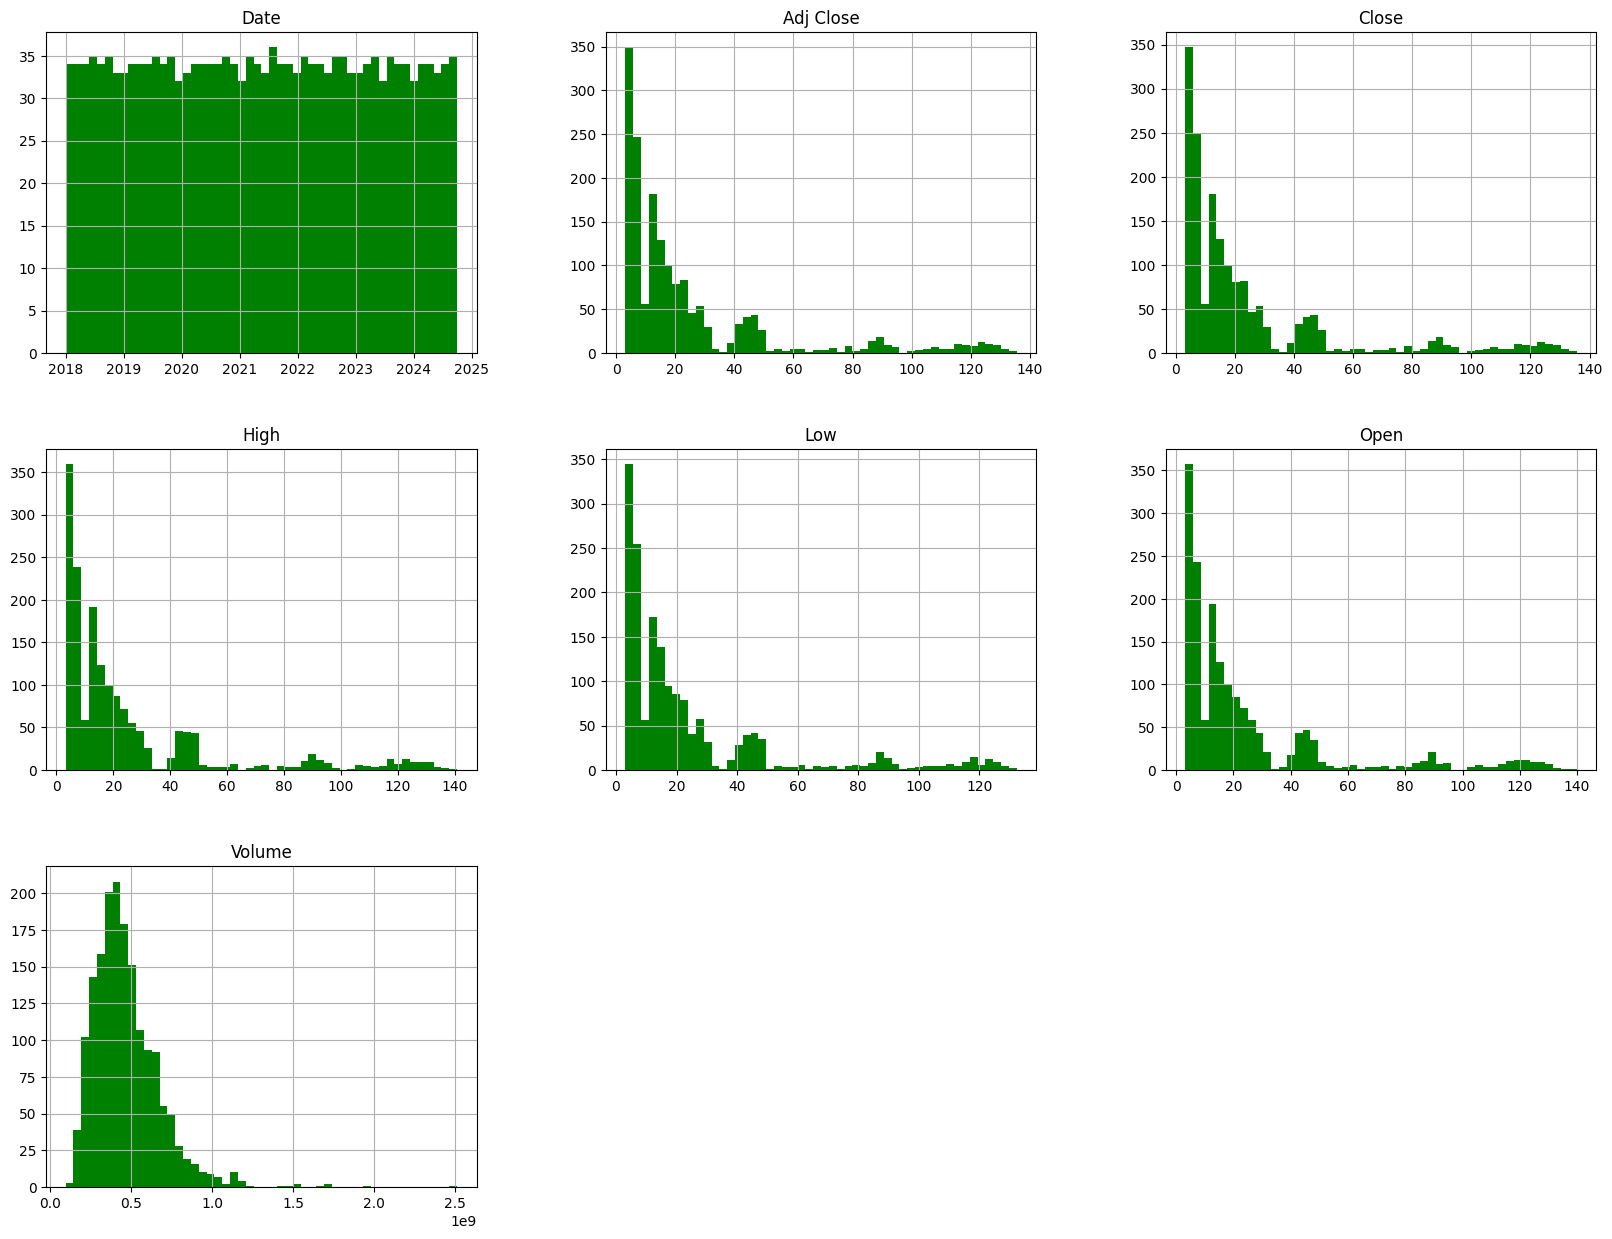

In [146]:
#histogram
df_nvidia.hist(bins=50, color="green", figsize=(20,15))
plt.savefig('nvidia-histrogram.png')
plt.show()

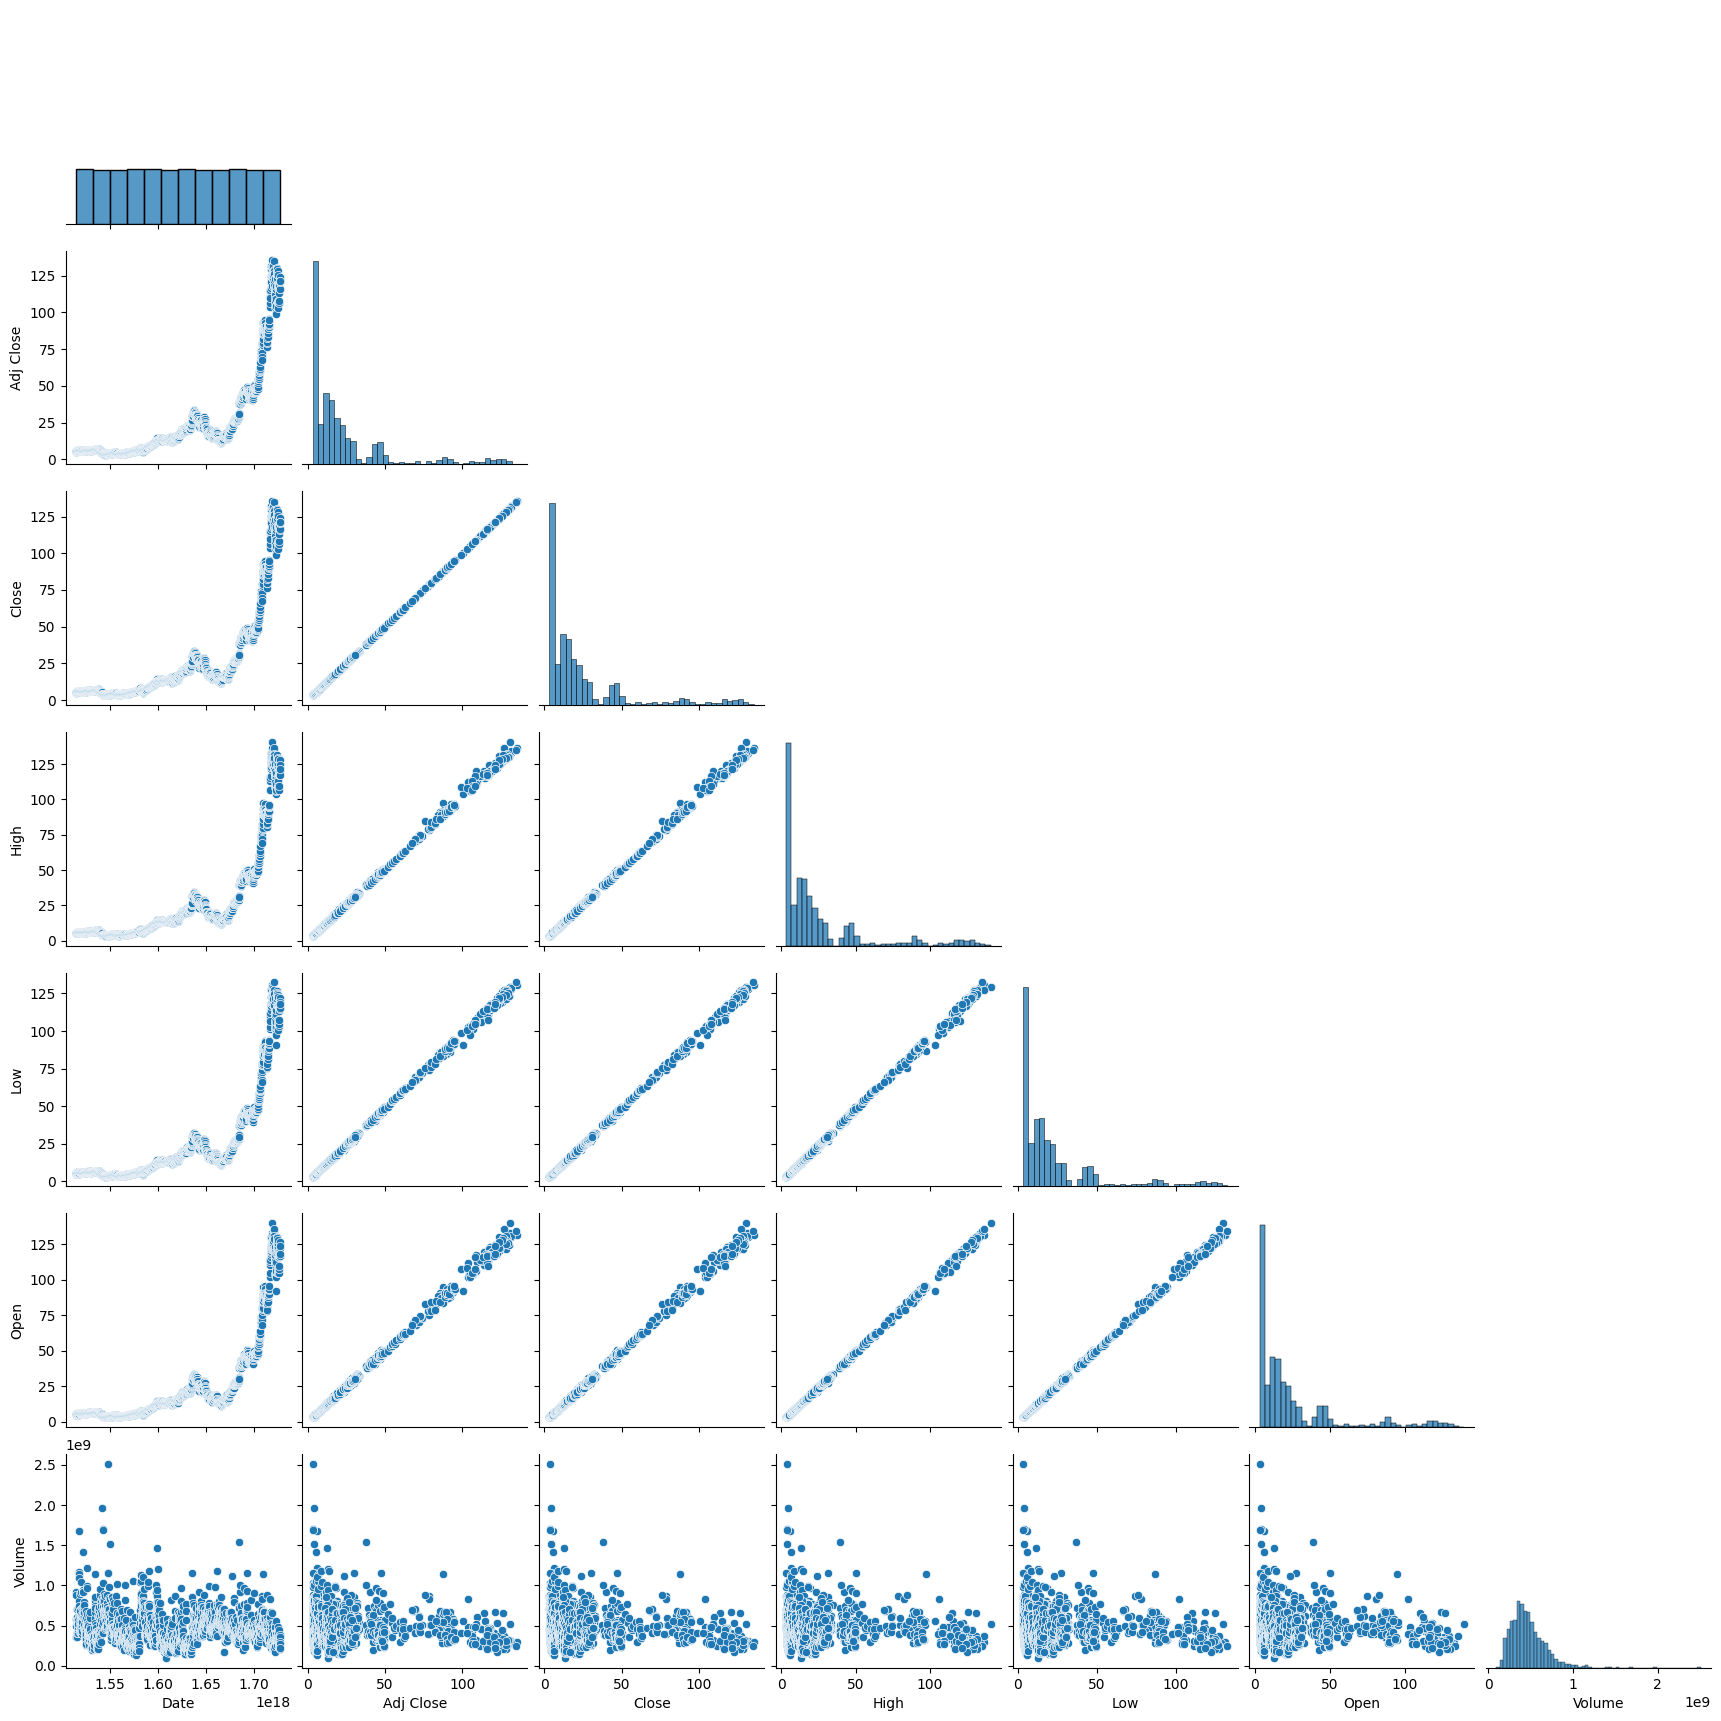

In [147]:
# Looking at some real data, where we don't know the number of clusters already
for col in df_nvidia.columns:
    df_nvidia[col] = pd.to_numeric(df_nvidia[col])

sns.pairplot(df_nvidia, corner=True)
plt.savefig('nvidia-cluster.png')
plt.show()

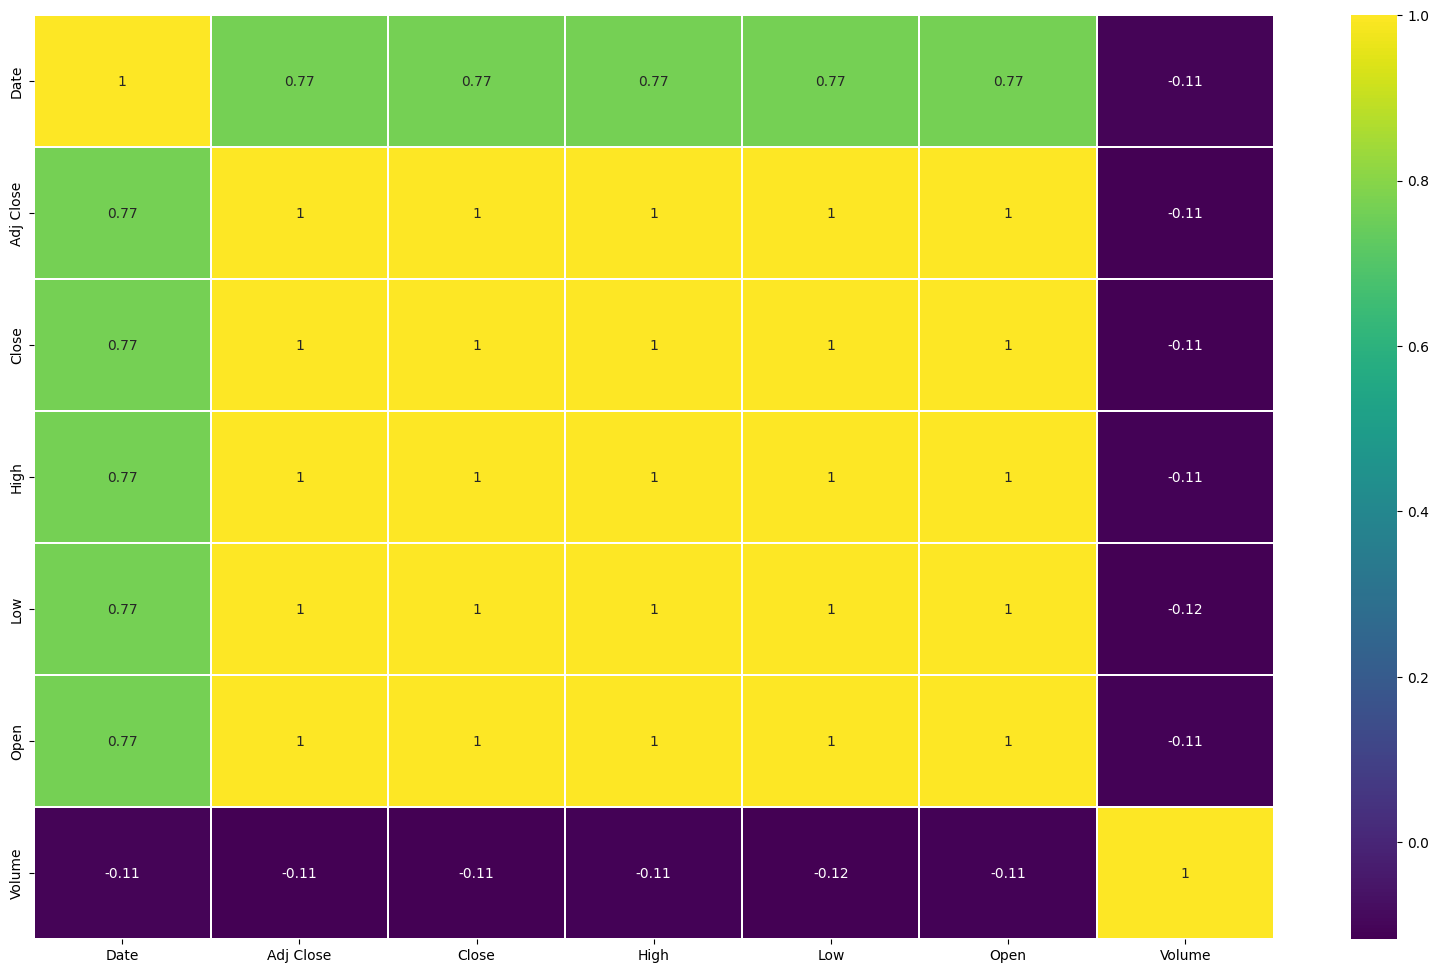

In [148]:
# Show correlation
fig, ax = plt.subplots(figsize = (20, 12))
ax = sns.heatmap(df_nvidia.corr(), cmap='viridis', cbar=True, annot=True, linewidths=0.2,ax=ax)
# save image
plt.savefig('nvidia-corr.png')
plt.show()

In [149]:
if df_nvidia.index.name == "Date":
    df_nvidia = df_nvidia.reset_index()

In [150]:
# Feature Engineering (Moving Averages and Volatility)

# Calculate the 50-day Simple Moving Average (SMA), which smooths the closing price by averaging it over the last 50 days to identify short-term trends.
df_nvidia['SMA_50'] = df_nvidia['Close'].rolling(window=50).mean()

# Calculate the 200-day Simple Moving Average (SMA), which smooths the closing price over the last 200 days to identify long-term trends.
df_nvidia['SMA_200'] = df_nvidia['Close'].rolling(window=200).mean()

# Calculate the 50-day rolling standard deviation (Volatility), which measures the dispersion of closing prices over the last 50 days, indicating market volatility.
df_nvidia['Volatility'] = df_nvidia['Close'].rolling(window=50).std()

# Calculate daily returns to measure volatility
df_nvidia["Daily Return"] = df_nvidia["Close"].pct_change()

# Calculate rolling standard deviation (volatility) over a 20-day window
df_nvidia["Rolling Volatility"] = df_nvidia["Daily Return"].rolling(window=20).std()

df_nvidia.dropna(inplace=True)

In [151]:
# Convert "Date" to datetime format
df_nvidia["Date"] = pd.to_datetime(df_nvidia["Date"], errors='coerce')

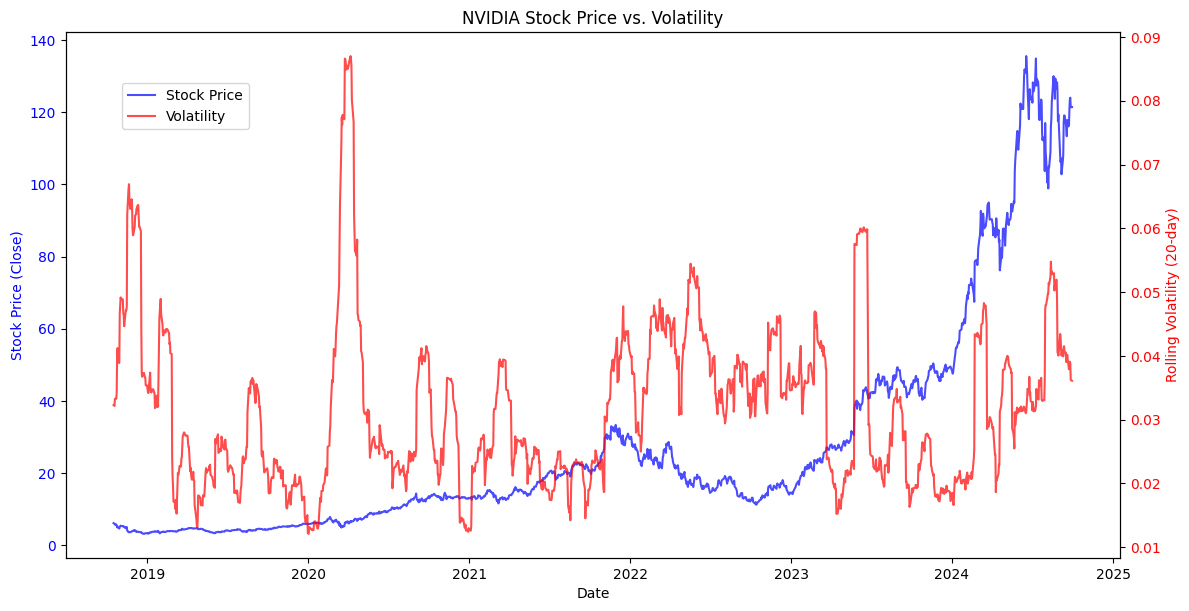

In [152]:
# Plot stock price and volatility
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stock price
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price (Close)", color="blue")
line1, = ax1.plot(df_nvidia["Date"], df_nvidia["Close"], label="Stock Price", color="blue", alpha=0.7)
ax1.tick_params(axis="y", labelcolor="blue")

# Create second y-axis for volatility
ax2 = ax1.twinx()
ax2.set_ylabel("Rolling Volatility (20-day)", color="red")
line2, = ax2.plot(df_nvidia["Date"], df_nvidia["Rolling Volatility"], label="Volatility", color="red", alpha=0.7)
ax2.tick_params(axis="y", labelcolor="red")

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Final formatting
fig.tight_layout()
plt.title("NVIDIA Stock Price vs. Volatility")
plt.savefig('nvidia-stock-price-volatility.png')
plt.show()

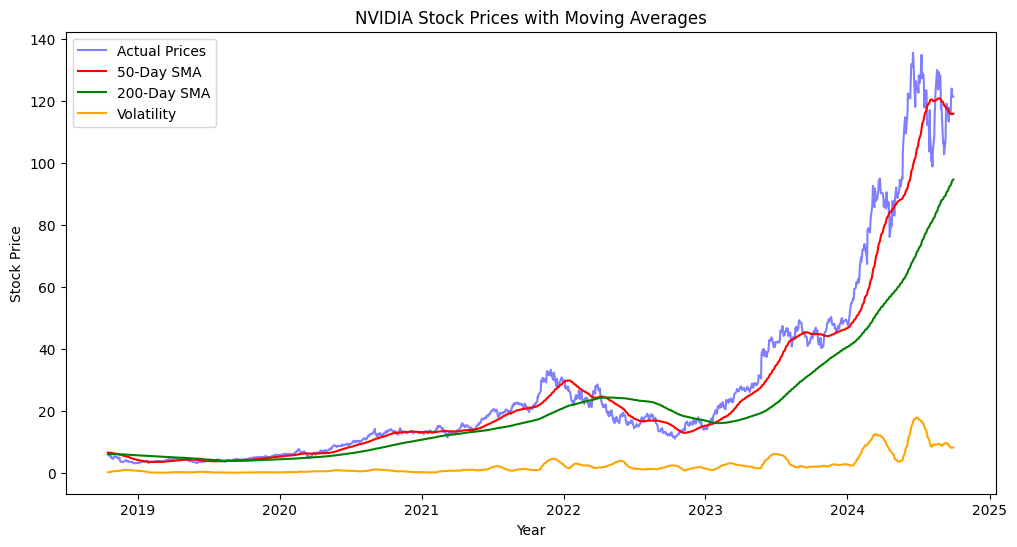

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(df_nvidia["Date"], df_nvidia["Close"], label="Actual Prices", color="blue", alpha=0.5)
plt.plot(df_nvidia["Date"], df_nvidia["SMA_50"], label="50-Day SMA", color="red")
plt.plot(df_nvidia["Date"], df_nvidia["SMA_200"], label="200-Day SMA", color="green")
plt.plot(df_nvidia["Date"], df_nvidia["Volatility"], label="Volatility", color="orange")
plt.legend()
plt.title("NVIDIA Stock Prices with Moving Averages")
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.savefig('nvidia-stock-price-moving-average.png')
plt.show()

In [154]:
# Define features and target
features = ['Adj Close', 'High', 'Low', 'Open', 'Volume', 'SMA_50', 'SMA_200', 'Volatility']
target = 'Close'

In [155]:
# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_nvidia[features])
y_scaled = scaler_y.fit_transform(df_nvidia[[target]])

# Create lag sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i - seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

sequence_length = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(
    monitor='loss', patience=15, min_delta=0.0001, restore_best_weights=True, verbose=1
)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=32, callbacks=[early_stopping], verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

Epoch 1/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0277 - val_loss: 0.0011
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.0033 - val_loss: 7.6641e-04
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0029 - val_loss: 9.5493e-04
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0031 - val_loss: 6.9940e-04
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0022 - val_loss: 6.5503e-04
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.0023 - val_loss: 5.8330e-04
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0017 - val_loss: 5.6444e-04
Epoch 8/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0022 - val_loss: 5.7049e-04
Epoch 9/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0022 - val_loss: 5.9371e-04
Epoch 10/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0018 - val_loss: 5.5780e-04
Epoch 11/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.0017 - val_loss: 6.7213e-04


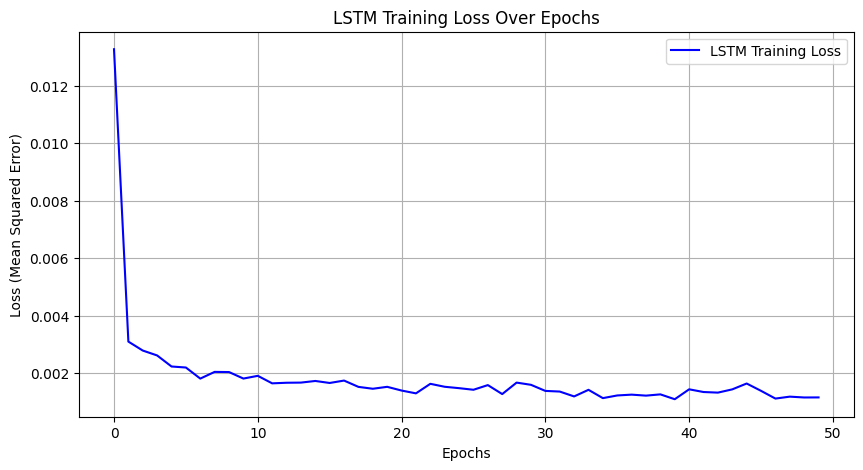

In [156]:
# Plot training Loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="LSTM Training Loss", color="blue")

# Customize the Plot
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean Squared Error)")
plt.title("LSTM Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('nvidia-LSTM-loss-epochs.png')
plt.show()

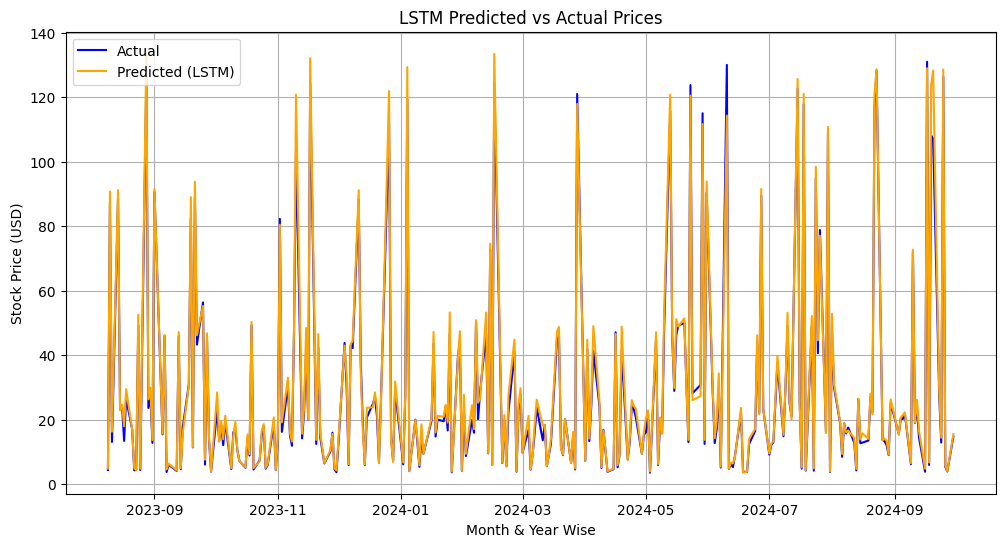

In [157]:
# Plot actual vs predicted
dates = df_nvidia['Date'][-len(y_actual):]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_actual, label='Actual', color='blue')
plt.plot(dates, y_pred, label='Predicted (LSTM)', color='orange')
plt.title("LSTM Predicted vs Actual Prices")
plt.xlabel("Month & Year Wise")
plt.ylabel("Stock Price (USD)")
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('nvidia-LSTM-Predicted-actual-price.png')
plt.show()

In [158]:
# Linear Regression
X_train_lr = X_train.reshape(X_train.shape[0], -1)  # Flatten 3D → 2D
X_test_lr = X_test.reshape(X_test.shape[0], -1)

# Train Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_lr, y_train)
y_pred_lr = linear_model.predict(X_test_lr)

# Inverse transform predictions and actual values
y_pred_lr_inv = scaler_y.inverse_transform(y_pred_lr)
y_actual_lr_inv = scaler_y.inverse_transform(y_test)

In [159]:
# Flatten for Random Forest
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# Train Random Forest
random_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_model.fit(X_train_rf, y_train)
y_pred_rf = random_model.predict(X_test_rf)

# Inverse transform predictions and targets
y_pred_rf_inv = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1))
y_actual_rf_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [160]:
from pmdarima import auto_arima
# Train-test split (80/20)
train_size = int(len(df_nvidia) * 0.8)
train, test = df_nvidia['Close'][:train_size], df_nvidia['Close'][train_size:]

# Auto ARIMA to select best (p,d,q)
auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=False, suppress_warnings=True)
best_order = auto_model.order
print(f"Best ARIMA Order: ({best_order})")

# Train ARIMA model with best order
arima_model = ARIMA(train, order=best_order)
fitted_model = arima_model.fit()

# Forecast
forecast = fitted_model.forecast(steps=len(test))

Best ARIMA Order: ((2, 1, 2))


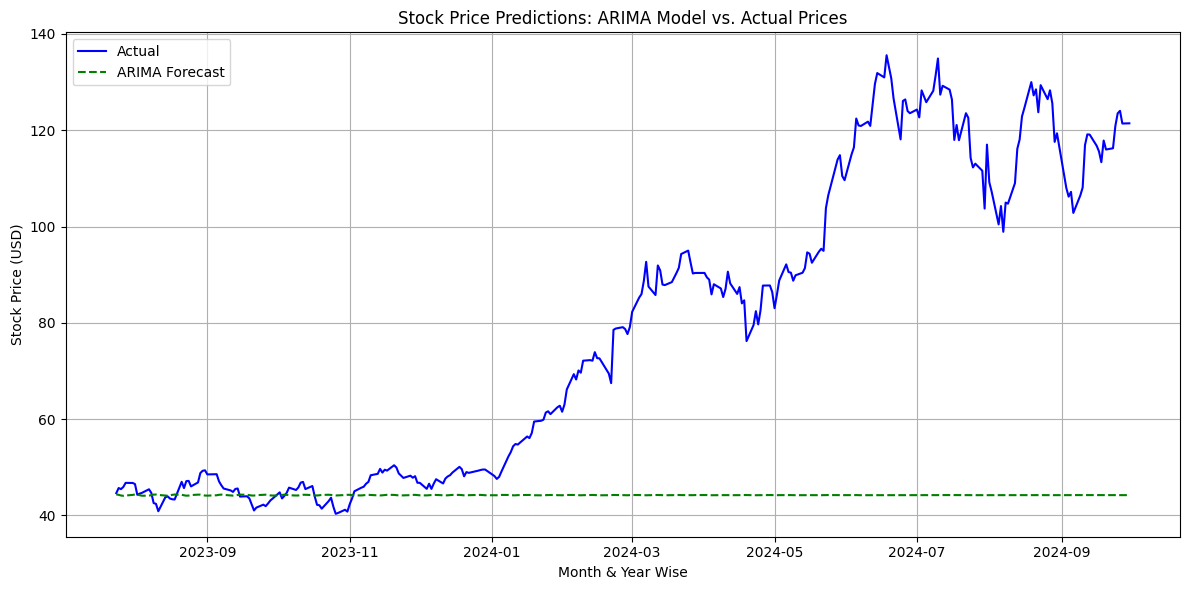

In [162]:
# Convert 'Date' column to datetime if it exists
if 'Date' in df_nvidia.columns:
    df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'], unit='ns', errors='coerce')
    df_nvidia.set_index('Date', inplace=True)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(df_nvidia.index[train_size:], test, label='Actual', color='blue')
plt.plot(df_nvidia.index[train_size:], forecast, label='ARIMA Forecast', color='green', linestyle='--')
plt.title("Stock Price Predictions: ARIMA Model vs. Actual Prices")
plt.xlabel("Month & Year Wise")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('nvidia-ARIMA-Predicted-actual-price.png')
plt.show()

In [163]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Performance of {model_name}:")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"R² Score (coefficient of determination): {r2:.4f}")
    return model_name, mae, rmse, r2

Performance of Linear Regression:
MAE (Mean Absolute Error): 1.1469
RMSE (Root Mean Squared Error): 1.8634
R² Score (coefficient of determination): 0.9964
Performance of Random Forest:
MAE (Mean Absolute Error): 0.6159
RMSE (Root Mean Squared Error): 1.1395
R² Score (coefficient of determination): 0.9986
Performance of LSTM:
MAE (Mean Absolute Error): 1.8225
RMSE (Root Mean Squared Error): 3.1827
R² Score (coefficient of determination): 0.9894
Performance of ARIMA:
MAE (Mean Absolute Error): 34.4113
RMSE (Root Mean Squared Error): 46.1709
R² Score (coefficient of determination): -1.1905


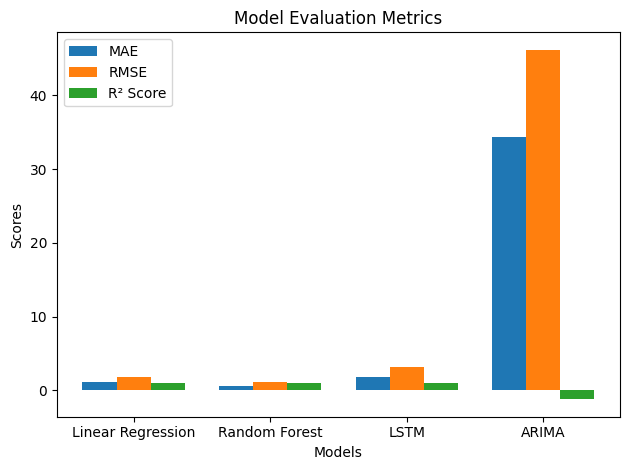

In [164]:
# Collecting the data
results = [
    evaluate_model(y_actual_lr_inv, y_pred_lr_inv, "Linear Regression"),
    evaluate_model(y_actual_rf_inv, y_pred_rf_inv, "Random Forest"),
    evaluate_model(y_actual, y_pred.flatten(), "LSTM"),
    evaluate_model(test, forecast, "ARIMA"),
]

# Unpacking results
model_names, mae_values, rmse_values, r2_values = zip(*results)

# Creating the bar chart
x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, mae_values, width, label='MAE')
ax.bar(x, rmse_values, width, label='RMSE')
ax.bar(x + width, r2_values, width, label='R² Score')

ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_xlabel('Models')
ax.legend()
plt.tight_layout()
plt.savefig('nvidia-model-evaluation.png')
plt.show()


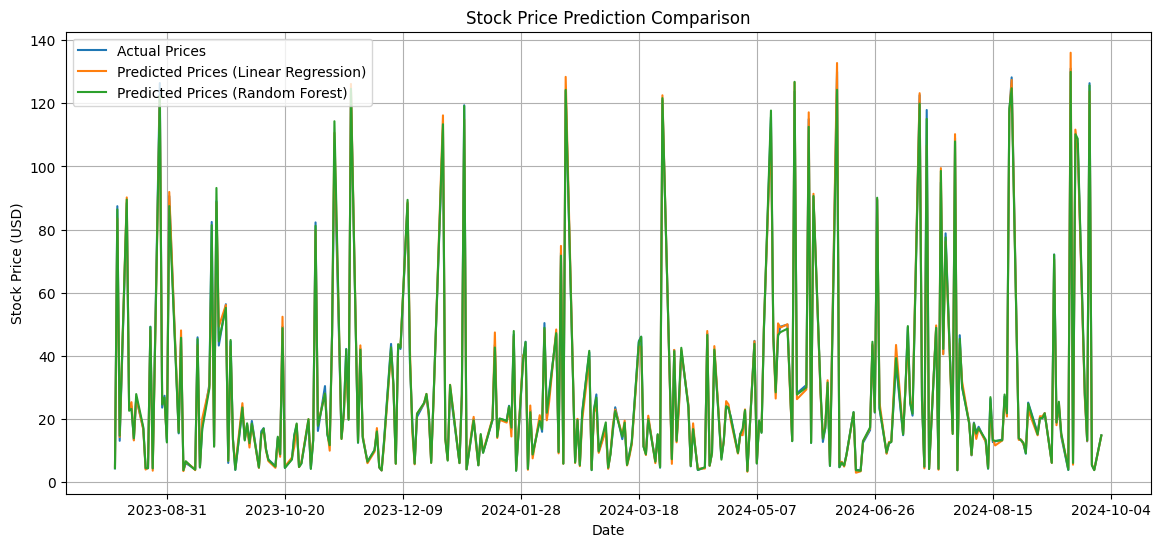

In [165]:
# Convert 'Date' column to datetime if it exists
if 'Date' in df_nvidia.columns:
    df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'], unit='ns', errors='coerce')
    df_nvidia.set_index('Date', inplace=True)

# Time Horizon Impact
plt.figure(figsize=(14, 6))
plt.plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual Prices')
plt.plot(df_nvidia.index[-len(y_test):], y_pred_lr_inv, label='Predicted Prices (Linear Regression)')
plt.plot(df_nvidia.index[-len(y_test):], y_pred_rf_inv, label='Predicted Prices (Random Forest)')

# Format x-axis for better readability
plt.xticks(rotation=0)  # Rotate x-axis labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit number of labels

plt.legend(loc='upper left')
plt.title("Stock Price Prediction Comparison")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.grid(True)
plt.savefig('nvidia-time-horizon-impact.png')
plt.show()

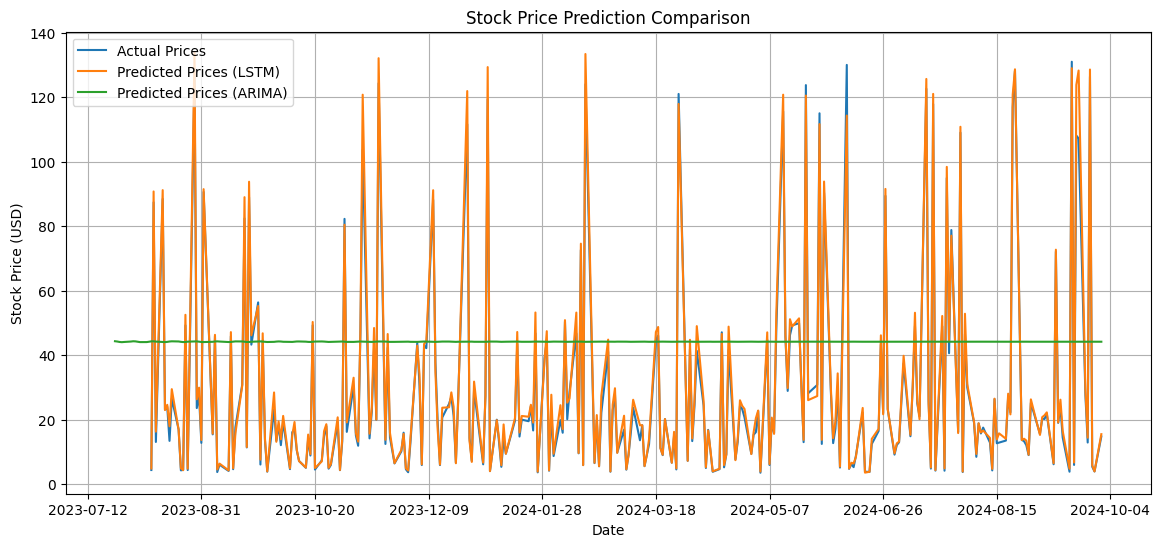

In [166]:
# Time Horizon Impact
plt.figure(figsize=(14, 6))
plt.plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual Prices')
plt.plot(df_nvidia.index[-len(y_test):], y_pred.flatten(), label='Predicted Prices (LSTM)')
plt.plot(df_nvidia.index[-len(test):], forecast, label='Predicted Prices (ARIMA)')


# Format x-axis for better readability
plt.xticks(rotation=0)  # Rotate x-axis labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit number of labels

plt.legend(loc='upper left')
plt.title("Stock Price Prediction Comparison")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.grid(True)
plt.savefig('nvidia-time-horizon-predication-comparison.png')
plt.show()